<a href="https://colab.research.google.com/github/MichaelangeloVelalopoulos/diploma-energy-market/blob/main/notebooks/NBeatsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git config --global user.email "michael.velalopoulos@gmail.com"
!git config --global user.name "michaelangelovelalopoulos"


In [3]:
!git clone https://github.com/MichaelangeloVelalopoulos/diploma-energy-market.git


Cloning into 'diploma-energy-market'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 5), reused 26 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 296.75 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [8]:
!find /content -maxdepth 3 -name "*.ipynb"


/content/drive/MyDrive/PrologIntro.ipynb


In [ ]:
# ================================================================
# 0. Setup: GPU, clone repo, install deps (τρέξε αυτό πρώτο)
# ================================================================
import os

# Δες αν έχει GPU
import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Αν ΔΕΝ έχεις ήδη κάνει clone:
if not os.path.exists("/content/diploma-energy-market"):
    !git clone https://github.com/MichaelangeloVelalopoulos/diploma-energy-market.git

%cd /content/diploma-energy-market

# Προαιρετικά: αν χρειαστεί κάποια library
!pip install --quiet pandas numpy scikit-learn


PyTorch: 2.9.0+cu126
CUDA available: False
Cloning into 'diploma-energy-market'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 0), reused 14 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 13.60 KiB | 4.53 MiB/s, done.
/content/diploma-energy-market


In [6]:



# ================================================================
# 1. Imports
# ================================================================
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# ================================================================
# 2. Load dataset (idm_dataset_2024.csv)
#    - Αν το csv είναι αλλού, άλλαξε το path
# ================================================================
csv_path = "/content/idm_dataset_2024.csv"

df = pd.read_csv(csv_path, parse_dates=["DELIVERY_MTU"])
print(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
# ================================================================
# 3. Επιλογή auction & basic preprocessing
# ================================================================
# π.χ. AUCTION_NAME = "IDA1" (ή "IDA2", "IDA3")
AUCTION_NAME = "IDA1"

# Φιλτράρουμε το συγκεκριμένο auction
df_auction = df[df["AUCTION"] == AUCTION_NAME].copy()

# Ταξινόμηση χρονικά
df_auction = df_auction.sort_values("DELIVERY_MTU").reset_index(drop=True)

print(AUCTION_NAME, "rows:", len(df_auction))

# ---- TARGET ----
# Στο CSV υπάρχουν: MCP (IDM price), DAM_MCP (DAM price).
# Target για πρόβλεψη IDM = MCP
target_col = "MCP"

# ---- FEATURES ----
# Κρατάμε ΜΟΝΟ αριθμητικές στήλες και πετάμε το target από μέσα.
numeric_cols = df_auction.select_dtypes(include=["number"]).columns.tolist()

feature_cols = [c for c in numeric_cols if c != target_col]

print("Number of numeric features:", len(feature_cols))
print("Example features:", feature_cols[:20])

# ================================================================
# 4. Time-based split 70/30
# ================================================================
n = len(df_auction)
split_idx = int(n * 0.7)

train_df = df_auction.iloc[:split_idx].reset_index(drop=True)
test_df  = df_auction.iloc[split_idx:].reset_index(drop=True)

print("Train rows:", len(train_df), "| Test rows:", len(test_df))

# Κρατάμε μόνο features + target (για το μοντέλο)
import numpy as np

train_features = train_df[feature_cols].values.astype(np.float32)
train_target   = train_df[target_col].values.astype(np.float32)

test_features  = test_df[feature_cols].values.astype(np.float32)
test_target    = test_df[target_col].values.astype(np.float32)

print("train_features shape:", train_features.shape)
print("test_features shape :", test_features.shape)



  TARGET BIDDING_ZONE_DESCR SIDE_DESCR      DDAY ASSET_DESCR CLASSIFICATION  \
0   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
1   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
2   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
3   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
4   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   

         DELIVERY_MTU  DELIVERY_DURATION  SORT     MCP  ...  \
0 2024-06-16 00:00:00                 60     1  112.08  ...   
1 2024-06-16 01:00:00                 60     2  120.40  ...   
2 2024-06-16 02:00:00                 60     3  100.29  ...   
3 2024-06-16 03:00:00                 60     4   93.70  ...   
4 2024-06-16 04:00:00                 60     5   89.75  ...   

   AGG__mean__wind_speed_10m__rollmean3  \
0                              5.418359   
1                              5.341667   
2                

# Νέα ενότητα

In [7]:
# ================================================================
# 5. N-BEATS Dataset (sliding windows)
# ================================================================
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, X, y, lookback=48, horizon=1):
        """
        X: [N, num_features]
        y: [N]
        lookback: πόσα βήματα χρησιμοποιεί σαν input
        horizon: πόσα βήματα μπροστά προβλέπει (εδώ 1)
        """
        self.X = X
        self.y = y
        self.lookback = lookback
        self.horizon = horizon

        self.length = len(X) - lookback - horizon + 1

    def __len__(self):
        return max(self.length, 0)

    def __getitem__(self, idx):
        # input window: [lookback, num_features]
        x_win = self.X[idx : idx + self.lookback]
        # target: επόμενο βήμα MCP_IDA
        y_win = self.y[idx + self.lookback : idx + self.lookback + self.horizon]
        return torch.from_numpy(x_win), torch.from_numpy(y_win)


LOOKBACK = 48   # 2 μέρες * 24h (αν έχεις hourly data, αλλιώς απλά παράθυρο 48 steps)
HORIZON  = 1    # 1 βήμα μπροστά (επόμενο MCP_IDA)

train_ds = TimeSeriesWindowDataset(train_features, train_target, LOOKBACK, HORIZON)
test_ds  = TimeSeriesWindowDataset(test_features,  test_target,  LOOKBACK, HORIZON)

len(train_ds), len(test_ds)


(18295, 7814)

In [8]:
# ================================================================
# 6. N-BEATS Block & Model (simplified version)
# ================================================================
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_dim=256, n_layers=4):
        super().__init__()
        layers = []
        for _ in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_dim))
            layers.append(nn.ReLU())
            input_size = hidden_dim
        self.fc = nn.Sequential(*layers)
        self.theta_layer = nn.Linear(hidden_dim, theta_size)

    def forward(self, x):
        """
        x: [batch, input_size]
        """
        x = self.fc(x)
        theta = self.theta_layer(x)
        return theta


class NBeatsModel(nn.Module):
    def __init__(self, num_features, lookback, horizon, hidden_dim=256, n_blocks=3, n_layers=4):
        super().__init__()
        self.num_features = num_features
        self.lookback = lookback
        self.horizon = horizon

        # input_size: lookback * num_features (flattened)
        input_size = lookback * num_features
        theta_size = horizon  # univariate forecast

        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, hidden_dim, n_layers)
            for _ in range(n_blocks)
        ])

    def forward(self, x):
        """
        x: [batch, lookback, num_features]
        """
        batch_size = x.size(0)
        # flatten
        x = x.reshape(batch_size, -1)

        forecast = 0
        for block in self.blocks:
            theta = block(x)
            # direct forecast
            forecast = forecast + theta

        # forecast: [batch, horizon]
        return forecast


In [9]:
# ================================================================
# 7. DataLoaders
# ================================================================
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)


(143, 62)

In [10]:
# ================================================================
# 8. Init μοντέλου, optimizer, loss
# ================================================================
num_features = len(feature_cols)

model = NBeatsModel(
    num_features=num_features,
    lookback=LOOKBACK,
    horizon=HORIZON,
    hidden_dim=256,
    n_blocks=3,
    n_layers=4,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


NBeatsModel(
  (blocks): ModuleList(
    (0-2): 3 x NBeatsBlock(
      (fc): Sequential(
        (0): Linear(in_features=4416, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): ReLU()
        (6): Linear(in_features=256, out_features=256, bias=True)
        (7): ReLU()
      )
      (theta_layer): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)


In [11]:
# ================================================================
# 9. Training loop
# ================================================================
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)        # [B, L, F]
            yb = yb.to(device)        # [B, H]

            preds = model(xb)         # [B, H]
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0).reshape(-1)
    all_targets = np.concatenate(all_targets, axis=0).reshape(-1)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    return mse, rmse, mae, all_preds, all_targets


EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_mse = np.mean(train_losses)
    test_mse, test_rmse, test_mae, _, _ = evaluate(model, test_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"Train MSE: {train_mse:.4f} | "
        f"Test MSE: {test_mse:.4f} | "
        f"RMSE: {test_rmse:.4f} | "
        f"MAE: {test_mae:.4f}"
    )

# Τελική αξιολόγηση
test_mse, test_rmse, test_mae, y_pred, y_true = evaluate(model, test_loader)
print("\n===== ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ (N-BEATS", AUCTION_NAME, ") =====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)

# Αποθήκευση μοντέλου
os.makedirs("models", exist_ok=True)
model_path = f"models/nbeats_{AUCTION_NAME.lower()}.pt"
torch.save(model.state_dict(), model_path)
print("Μοντέλο αποθηκευμένο στο", model_path)


Epoch 01 | Train MSE: 11421481083.6700 | Test MSE: 21816.3867 | RMSE: 147.7037 | MAE: 133.3762
Epoch 02 | Train MSE: 49880064.0833 | Test MSE: 3157416.0000 | RMSE: 1776.9119 | MAE: 1775.7828
Epoch 03 | Train MSE: 158348045.9009 | Test MSE: 8971802.0000 | RMSE: 2995.2966 | MAE: 2994.6277
Epoch 04 | Train MSE: 940427.8844 | Test MSE: 16997.0234 | RMSE: 130.3726 | MAE: 114.1408
Epoch 05 | Train MSE: 10544.2267 | Test MSE: 4432.5371 | RMSE: 66.5773 | MAE: 36.7323
Epoch 06 | Train MSE: 16037.0591 | Test MSE: 4461.5942 | RMSE: 66.7952 | MAE: 36.8335
Epoch 07 | Train MSE: 753688.5224 | Test MSE: 45555664.0000 | RMSE: 6749.4936 | MAE: 6749.2007
Epoch 08 | Train MSE: 7250020.1265 | Test MSE: 92516.4141 | RMSE: 304.1651 | MAE: 299.2706
Epoch 09 | Train MSE: 15597450.9501 | Test MSE: 222920.7500 | RMSE: 472.1448 | MAE: 467.9237
Epoch 10 | Train MSE: 48212.4122 | Test MSE: 14948.5283 | RMSE: 122.2642 | MAE: 105.1146
Epoch 11 | Train MSE: 55400.7363 | Test MSE: 267739.8125 | RMSE: 517.4358 | MAE: 5

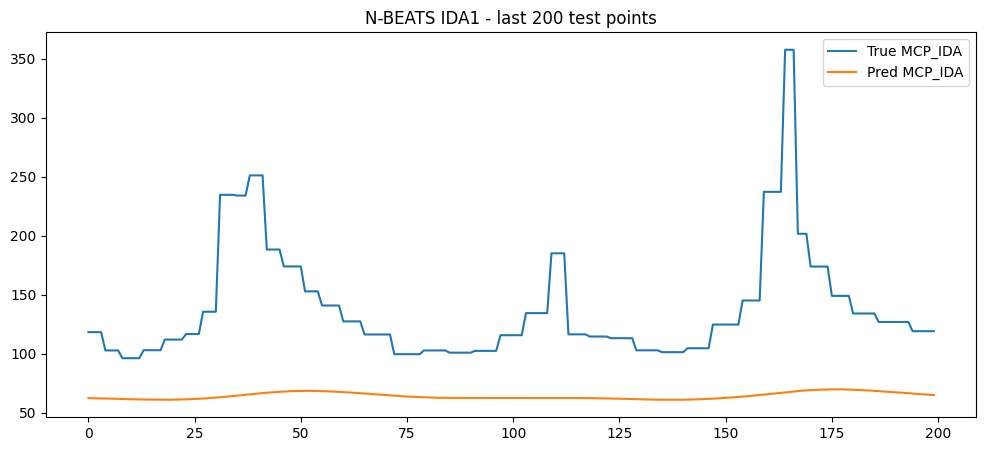

In [12]:
# ================================================================
# 10. Γρήγορο plot πραγματικό vs predicted για τα τελευταία 200 σημεία
# ================================================================
import matplotlib.pyplot as plt

N = 200
plt.figure(figsize=(12, 5))
plt.plot(y_true[-N:], label="True MCP_IDA")
plt.plot(y_pred[-N:], label="Pred MCP_IDA")
plt.legend()
plt.title(f"N-BEATS {AUCTION_NAME} - last {N} test points")
plt.show()
